**Use this command to install Tensorflow, if it is not already installed**

In [ ]:
!pip install tensorflow

**Importing the python libs and packages**

## Work Description

We recall that in our previous notebook AutoMPG_EDA, we introduced the dataset AutoMPG, described its content and analysed the different relationships between our target variable 'MPG' and the other discret and continuous variables present in the dataset. Then, we proceed to construct, assess, and refine various regression models using the scikit-learn package in our notebook, "AutoMPG_Comparing_ML_Models". The current notebook is dedicated to another type of solution to solve Auto MPG prediction problem. In the era of deep learning, we explore the potential of neural networks for regression tasks. Leveraging the Keras sequential package, our "AutoMPG_Keras_DNN_Model" notebook outlines the creation, evaluation, and fine-tuning of a basic deep learning regression model tailored to our dataset.

**AUTOMPG**: *Mileage per gallon performances of various cars*

The data is technical spec of cars. The dataset is downloaded from UCI Machine Learning Repository.

**Source**
 Origin: This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition.

**Attribute Information**

    * mpg: continuous
    * cylinders: multi-valued discrete
    * displacement: continuous
    * horsepower: continuous
    * weight: continuous
    * acceleration: continuous
    * model year: multi-valued discrete
    * origin: multi-valued discrete
    * car name: string (unique for each instance)

**Steps**

//TODO
    

In [57]:
from __future__ import absolute_import, print_function, division
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.utils import shuffle


print(tf.__version__)

#set random seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


2.15.0


# Task 1 : Data preparation for the training

### 1.1 Loading the data

In [58]:
dataset_path= 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']


In [59]:
dataset_raw= pd.read_csv(dataset_path, names=column_names, na_values='?', comment= "\t", sep=" ", skipinitialspace=True )

In [60]:
dataset_raw.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [61]:
dataset_raw.shape

(398, 8)


### 1.2 Describing the data

In [62]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [63]:
dataset_raw.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### 1.3 Cleaning the data

In [64]:
dataset= dataset_raw.copy()

In [65]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [66]:
#Dropping the examples which don't have 'Horspower' values
dataset = dataset.dropna()

### 1.3 Encoding the '*origin*'

Encoding the 'Origin' and adding the columns which corresponds to the 3 distinct origins: USA, EUROPE and Japan

In [67]:
origin = dataset.pop('Origin')

In [68]:
dataset['USA'] = (origin==1) * 1
dataset['Europe']= (origin==2) * 1
dataset['Japan']= (origin==3) * 1
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [69]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


### 1.4 Splitting the data into Training and Testing sets



In [70]:
print("Initial dataset shape : ",dataset.shape)
#The target value to be predicted
Y=dataset.pop('MPG')
#The predictors
X=dataset
#Shuffeling the data
X, Y = shuffle(X, Y, random_state=42)


Initial dataset shape :  (392, 10)


In [71]:
#Shuffling the data
#Splitting the data into training and testing data
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(313, 9)
(313,)
(79, 9)
(79,)


### 1.5 Scaling the data


It is good practice to scale features that use different scales and ranges.One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. Although a model might converge without feature scaling, scaling makes training much more stable.

In [72]:
X_train.describe().transpose()[['mean', 'std']]

,mean,std
Cylinders,5.472843,1.692763
Displacement,194.413738,104.242055
Horsepower,104.169329,38.818200
Weight,2983.785942,860.088320
Acceleration,15.607029,2.792564
Model Year,76.057508,3.641360
USA,0.626198,0.484587
Europe,0.169329,0.375643
Japan,0.204473,0.403962



**Scaling the data using Keras Normalization layer**

To integrate Scaling as part of the Keras model architecture, we can use the tf.keras.layers.experimental.preprocessing.Normalization layer. This approach allows us to include the scaling directly within the model, ensuring that any transformations are part of the model pipeline. Within Keras, there isn't a direct equivalent to StandardScaler from scikit-learn that explicitly states it performs Z-score normalization. However, the **Normalization layer** in Keras essentially performs the same function by normalizing the data to have 0 mean and a standard deviation of 1. In the following, we will create the  Normalization Layer for Standardization and test it :


The **tf.keras.layers.Normalization** is a clean and simple way to add feature normalization into your model.

In [73]:
#A function to create the normalization layer
def create_normalizer(train_data) :
  normalizer = tf.keras.layers.Normalization(axis=-1)
  #Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:
  #At this step normalizer calculates the mean and variance, and store them in the layer
  normalizer.adapt(train_data)
  return normalizer

In [74]:
# check the mean and variance stored  in the normalizer layer:
normalizer = create_normalizer(X_train)
print(normalizer.mean.numpy())

[[5.4728432e+00 1.9441376e+02 1.0416934e+02 2.9837859e+03 1.5607029e+01
  7.6057503e+01 6.2619805e-01 1.6932909e-01 2.0447285e-01]]


In [75]:
#When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[   4.    90.    71.  2223.    16.5   75.     0.     1.     0. ]]

Normalized: [[-0.87 -1.   -0.86 -0.89  0.32 -0.29 -1.29  2.21 -0.51]]


# Task 3. Creating the Keras DNN Model

### 3.1 Building the Model

In [76]:
#Fct to create a sequential Keras model having 3 dense layers
def build_Compile_Model(norm_layer, learning_rate=0.001) :
  model = tf.keras.Sequential ([
      norm_layer,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1) #The final Dense layer applies linear transformation per default
  ])

  #opt=tf.keras.optimizers.Adam(learning_rate=learning_rate)  # an alternative optimizer
  opt=tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae'])
  return model

In [77]:
#Build the model the normalization layer
model_base = build_Compile_Model (normalizer)
model_base.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_15 (Dense)            (None, 64)                640       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


### 3.2. Inspect the model

In [78]:
#We will run the untrained mode to predict 10 examples to check that there is no errors
results= model_base.predict(X_train[:10])
results


1/1 [==============================] - 0s 88ms/step


array([[-0.41382715],
       [ 0.26257503],
       [-0.21027176],
       [-0.4008432 ],
       [ 0.18237603],
       [-0.0457334 ],
       [-0.19583215],
       [-0.13558325],
       [ 0.00888155],
       [ 0.27083433]], dtype=float32)

### 3.3. Training the model

In [79]:
#Special class to print 'dots' while training the model
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, log) :
    if epoch %100 == 0 : print('')
    print('.', end='')


In [80]:
#Training the model
%%time
history= model_base.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    verbose=0, epochs=1000,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### 3.5 Making Predictions

In [81]:
#Computing the predictions
test_prediction = model_base.predict(X_test).flatten()

3/3 [==============================] - 0s 7ms/step


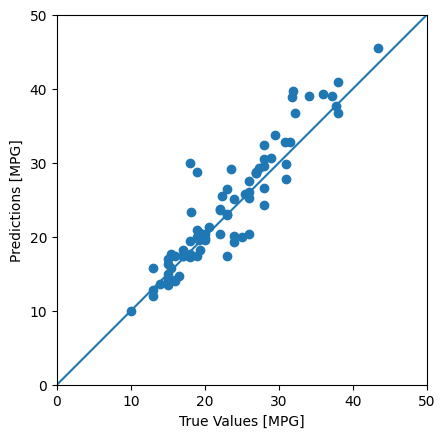

In [82]:
#Plotting the predictions of the Testing set
a = plt.axes(aspect='equal')
plt.scatter(Y_test, test_prediction)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Now, check the error distribution:

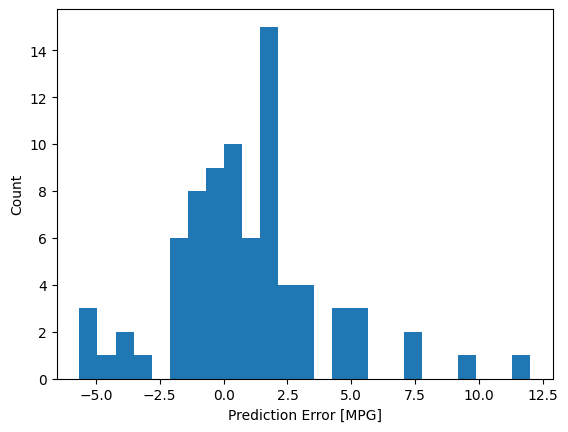

In [83]:
error = test_prediction - Y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')


### 3.4 Evaluating the model



In [84]:
#Evaluate the baseline model
def evaluate_model (model, X_train, Y_train, X_test, Y_test) :
  #Get the base evaluations
  loss_train, mse_train, mae_train  = model.evaluate(X_train, Y_train)
  loss_test, mse_test, mae_test = model.evaluate(X_test, Y_test)

  #making predictions
  y_pred_test = model.predict(X_test).flatten()
  y_pred_train = model.predict(X_train).flatten()

  mape = mean_absolute_percentage_error(Y_test, y_pred_test )
  r2_test= r2_score(Y_test, y_pred_test)
  r2_train= r2_score(Y_train, y_pred_train)

  #Store the different evaluations
  model_evals = {
    'loss_train' : loss_train ,
    'loss_test' : loss_test,
    'mse_train' : mse_train,
    'mse_test' : mse_test,
    'mae_train' : mae_train,
    'mae_test' : mae_test,
    'mape_testing' : mape,
    'r2-testing' : r2_test,
    'r2-train' : r2_train

  }

  return model_evals

In [85]:
baseline_evaluations = evaluate_model(model_base,  X_train, Y_train, X_test, Y_test)
baseline_evaluations['model_name'] = 'dnn_baseline'
baseline_evaluations

10/10 [==============================] - 0s 2ms/step


{'loss_train': 5.283418655395508,
 'loss_test': 10.019811630249023,
 'mse_train': 5.283418655395508,
 'mse_test': 10.019811630249023,
 'mae_train': 1.3972125053405762,
 'mae_test': 2.2510428428649902,
 'mape_testing': 0.09848950420929112,
 'r2-testing': 0.8026482481684312,
 'r2-train': 0.9164683208935632,
 'model_name': 'dnn_baseline'}

**Signs of Overfitting**

  The baseline model shows signs of overfitting. It has a significantly lower training loss and MAE compared to its testing loss and MAE, and the R² score drops from 0.916 (training) to 0.802 (testing). The higher training performance and lower testing performance indicate the model fits the training data too well but doesn't generalize as effectively. Hence, we will try to inscpect the training by visualizing the model training progress  across the different epochs. Then, we will try a technique to handle the overfitting problem called the [Early stopping](https://en.wikipedia.org/wiki/Early_stopping) method and inspect its results, then we will try to fine-turne the hyperparameters of our model to find the best parameters sets that reduces the overfitting while mainting the high performances of the model.

# Task 4. Improving the model using Early stopping

### 4.1 Inspecting the training

Visualize the model training progress using the stats stored in history

In [86]:
#Getting the training evals from the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
995,2.353958,2.353958,1.032596,13.773464,13.773464,2.372478,995
996,2.440295,2.440295,1.021776,14.433836,14.433836,2.476557,996
997,2.322083,2.322083,1.042303,13.896208,13.896208,2.505443,997
998,2.335330,2.335330,0.968034,13.975129,13.975129,2.430351,998
999,2.396514,2.396514,1.032189,15.245767,15.245767,2.401380,999


In [87]:
def plot_loss(history, metric='loss'):
  plt.figure()
  plt.plot(history.history[metric], label=metric)
  plt.plot(history.history['val_'+metric], label='val_'+metric)
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel(metric + '[MPG]')
  plt.legend()
  plt.title("Model "+metric+" progress during the training")
  plt.grid(True)

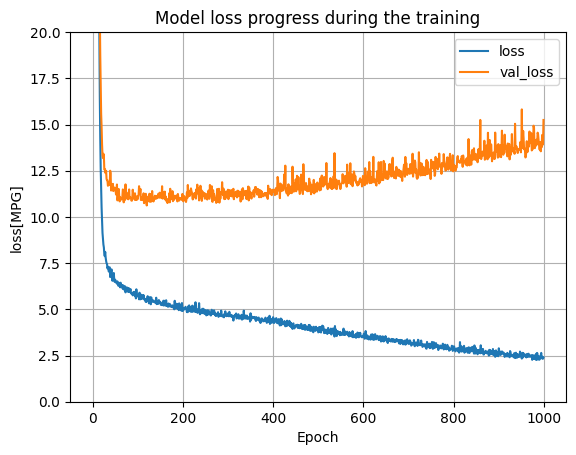

In [88]:
#Plotting the different metrics progress during the training
plot_loss(history)

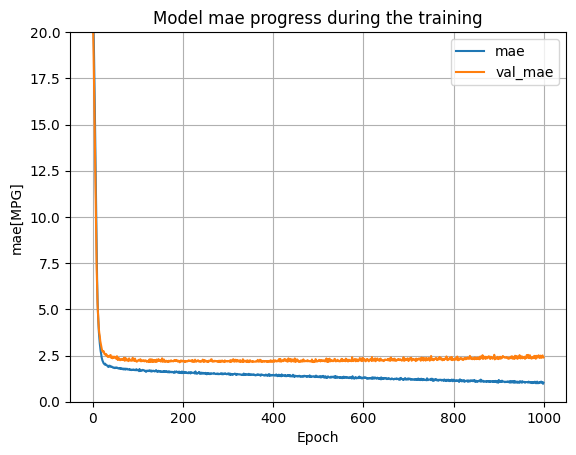

In [98]:
plot_loss(history, 'mae')

The previous plots show the loss(mse) and the mae of our model for each epoch on the training and validation datasets. From reviewing this plot and evaluation results for each epochs, we can see that the model performance on the validation set and on the training set, sits flat and even gets worse towards the end of training. We can also notice that there is an opportunity to stop the learning earlier, perhaps somewhere around epoch 100 to epoch 200.

Let's update the model.fit to automatically stop when the validation score doesn't improve. We will be using the **Early Stopping** Callback that test a Stopping condition for fixed amount of epochs. If a set of epochs elapses without any improvement, then we automatically stop the training. We will be testing two different values (10, 50) for the set of epochs to wait for before re-evaluating the improvement of the mode, it's called the 'patience' parameters.

### 4.2. Training the model with early Stopping parameter

In [90]:
#Building the model
def build_model_early_stopping(normalizer, patience=10) :
  model_es = build_Compile_Model(normalizer)
  #The patience paramater is the amount of epoch to wait for, before checking the improvement
  early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=patience)
  EPOCH= 1000
  #Training the model using new early stopping parameters
  history= model_es.fit(X_train, Y_train, epochs=EPOCH ,validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

  return model_es, history

In [91]:
model_es_10, history_10= build_model_early_stopping(normalizer, 10)



................................................................................

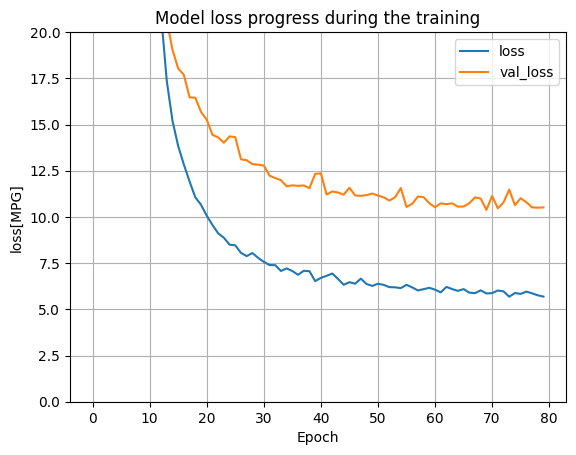

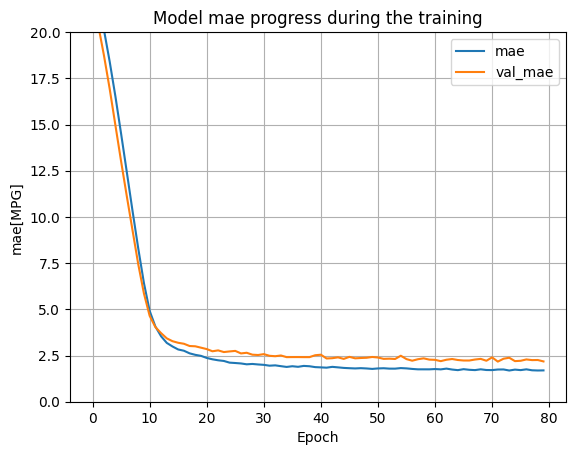

In [92]:
plot_loss(history_10, 'loss')
plot_loss(history_10, 'mae')


### 4.3 Evaluating the new model

In [101]:
model_es_10_evals = evaluate_model(model_es_10, X_train, Y_train, X_test, Y_test)
model_es_10_evals['model_name'] = 'dnn_early_stop_10'
model_es_10_evals

10/10 [==============================] - 0s 4ms/step


{'loss_train': 6.5857696533203125,
 'loss_test': 6.868824005126953,
 'mse_train': 6.5857696533203125,
 'mse_test': 6.868824005126953,
 'mae_train': 1.8042323589324951,
 'mae_test': 1.7896925210952759,
 'mape_testing': 0.08128220350456607,
 'r2-testing': 0.864710550648474,
 'r2-train': 0.8958779507981871,
 'model_name': 'dnn_early_stop_10'}

Now, we will experiment a higher value of the 'patience' parameter for the early stopping.


10/10 [==============================] - 0s 2ms/step


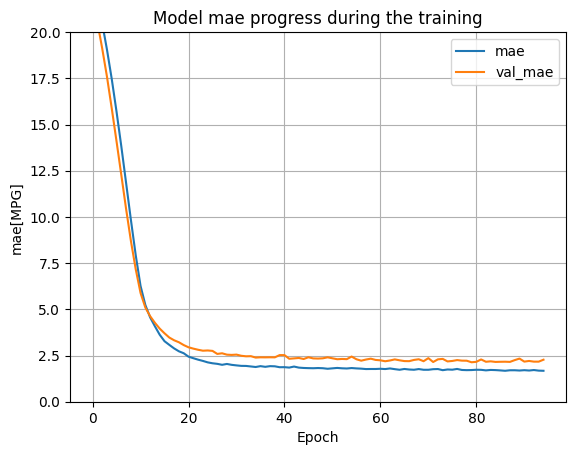

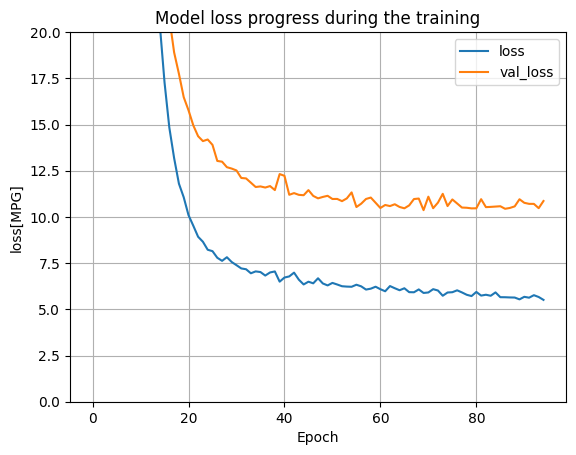

In [112]:
model_es_25, history_25= build_model_early_stopping(normalizer, 25)
model_es_25_evals = evaluate_model(model_es_25, X_train, Y_train, X_test, Y_test)
model_es_25_evals['model_name'] = 'dnn_early_stop_25'
model_es_25_evals
plot_loss(history_25, 'mae')
plot_loss(history_25, 'loss')


....................................................................................................
10/10 [==============================] - 0s 8ms/step


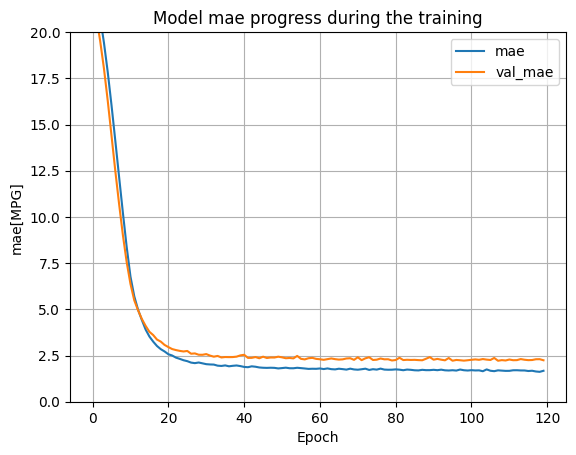

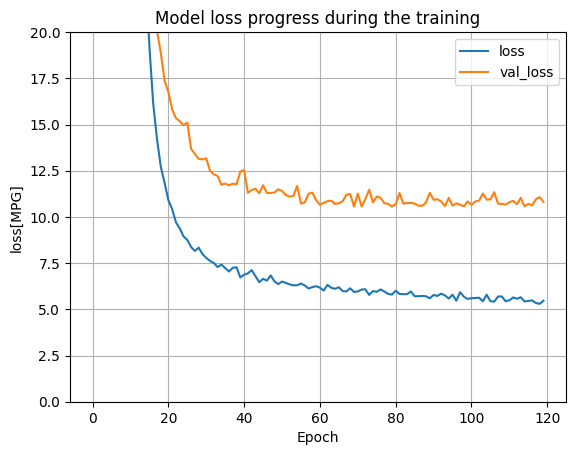

In [113]:
model_es_50, history_50= build_model_early_stopping(normalizer, 50)
model_es_50_evals = evaluate_model(model_es_50, X_train, Y_train, X_test, Y_test)
model_es_50_evals['model_name'] = 'dnn_early_stop_50'
model_es_50_evals

plot_loss(history_50, 'mae')
plot_loss(history_50, 'loss')

### 4.4 Comparing the evaluations

In [114]:
df_all_evals = pd.DataFrame([baseline_evaluations, model_es_10_evals, model_es_25_evals, model_es_50_evals])
df_all_evals



,loss_train,loss_test,mse_train,mse_test,mae_train,mae_test,mape_testing,r2-testing,r2-train,model_name
0,5.283419,10.019812,5.283419,10.019812,1.397213,2.251043,0.098490,0.802648,0.916468,dnn_baseline
1,6.585770,6.868824,6.585770,6.868824,1.804232,1.789693,0.081282,0.864711,0.895878,dnn_early_stop_10
2,6.714661,7.055412,6.714661,7.055412,1.798178,1.914752,0.086093,0.861035,0.893840,dnn_early_stop_25
3,6.309807,6.973294,6.309807,6.973294,1.743314,1.827941,0.083383,0.862653,0.900241,dnn_early_stop_50


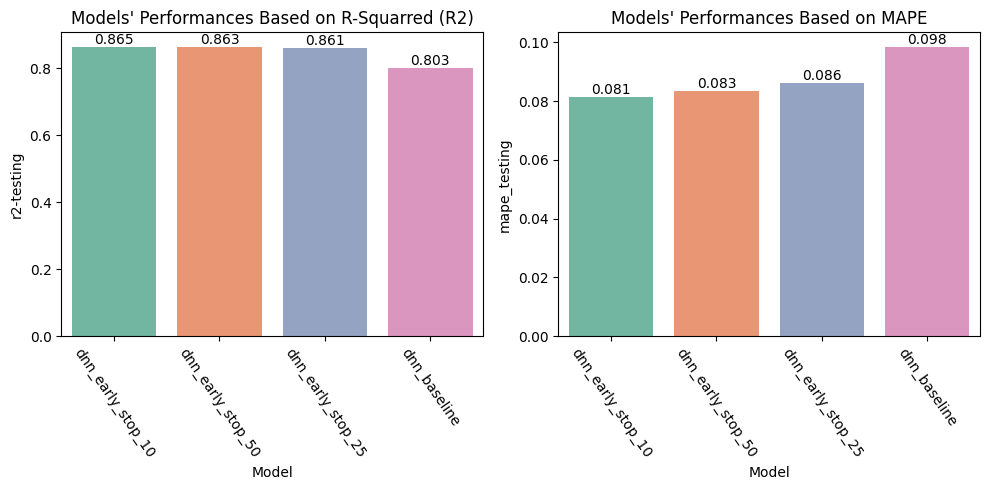

In [127]:
fig, ax= plt.subplots(1,2, figsize=(10,5))

#Plotting the R-2 performances for each model and scaling method
#Sorting the data according R2 on testing data
df_all_evals.sort_values(['r2-testing'], ascending=False, inplace=True)
bar=sns.barplot(data=df_all_evals, x='model_name', y='r2-testing', palette='Set2', ax=ax[0] )
ax[0].set_xlabel("Model")
ax[0].set_title("Models' Performances Based on R-Squarred (R2)")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-55)
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)

df_all_evals.sort_values(['mape_testing'], ascending=True, inplace=True)
bar=sns.barplot(data=df_all_evals, x='model_name', y='mape_testing', palette='Set2', ax=ax[1] )
ax[1].set_xlabel("Model")
ax[1].set_title("Models' Performances Based on MAPE")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-55)
for container in bar.containers:
  values = container.datavalues
  labels = ["{:.3f}".format(val) for val in values]
  bar.bar_label(container, labels=labels)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Observations

* **Early Stopping with Patience 10**: This model exhibits improved generalization compared to the baseline. Both the training and testing losses are more balanced, and the R² score is higher on the testing set (0.864) than the baseline (0.819). This indicates that early stopping with a patience of 10 helped reduce overfitting.

* **Early Stopping with Patience 25, 50**: These models doesn't show improvement in generalization and performances when using higher values of the patience parameter. The testing loss with patience 25 and 50 are slightly higher than the early stopping with patience 10, and the R² score on the testing set with patience 10 is the highest (0.865). The MAPE on the testing set is also the lowest (0.081) using patience 10.

The model with a patience of 10 shows the best balance between training and testing performance, with the highest R² testing score and the lowest testing MAPE. This suggests that not allowing the model to train longer before stopping early can lead to better generalization. Some variability in metrics across executions can be observed. This is normal due to the stochastic nature of neural network training, even when setting a random seed.

In the next section, we will try a different optimization method, adjust other hyperparameters such as learning rate, and experiment with different patience values, to see if they help improve the model's performances.

# Task 5 : hyperparameters finetuning of DNN model

//TODO

- Evaluate differents 'optimizers', learning rates and construct a deeper model.
- Use Cross-validation
- Compare with previous baseline dnn models
- Compare with the best ML model from previous experimentations

# Task 6. Saving the best model

Call tf.keras.Model.save to save a model's architecture, weights, and training configuration in a single model.keras zip archive.

An entire model can be saved in three different file formats (the new .keras format and two legacy formats: SavedModel, and HDF5). Saving a model as path/to/model.keras automatically saves in the latest format.
Note: For Keras objects it's recommended to use the new high-level .keras format for richer, name-based saving and reloading, which is easier to debug. The low-level SavedModel format and legacy H5 format continue to be supported for existing code.

You can switch to the SavedModel format by:

    Passing save_format='tf' to save()
    Passing a filename without an extension

You can switch to the H5 format by:

    Passing save_format='h5' to save()
    Passing a filename that ends in .h5

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)

*Custom objects (for example, subclassed models or layers) require special attention when saving and loading. Refer to the Saving custom objects section below.
see https://www.tensorflow.org/tutorials/keras/save_and_load

In [96]:

!mkdir -p saved_model

In [97]:
final_model.save('save_model/dnn_model_MPG_reg-3', save_format="tf") #saving in the newer format of keras => 'model.save('dnn_model_MPG_reg.keras')'


NameError: name 'final_model' is not defined

In [ ]:

!ls save_model/dnn_model_MPG_reg-3


Loading the model

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('save_model/dnn_model_MPG_reg-3')


In [ ]:
# Evaluate the restored model
loss, mse, mae = new_model.evaluate(X_test, Y_test, verbose=2)
print(f"Testing set Mean Absolute Error {mae:5.2f} MPG")


The model didn't lose its performances after the saving

I have tested the keras and the h5 format but it got errors. When loading the model, the shape of the input data is lost. This is due to the Normalization layer. A bug report exists in this link https://github.com/keras-team/keras/issues/15348